## **DebtRank Algorithm**

In [13]:
pip install numpy networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [27]:
class DebtRank:
    def __init__(self, W, equity, liabilities, shock_node, shock_size):
        """
        Initialize the DebtRank algorithm.
        
        Parameters:
        - W: np.array, weight matrix (N x N) representing the network of financial relationships
        - equity: np.array, initial equity of each node (length N)
        - liabilities: np.array, initial liabilities of each node (N x N)
        - shock_node: int, index of the node where the initial shock occurs
        - shock_size: float, the percentage drop in price (0 < shock_size <= 1)
        """
        self.W = W
        self.equity = equity.copy()
        self.liabilities = liabilities
        self.shock_node = shock_node
        self.shock_size = shock_size
        self.N = len(equity)  # Number of nodes
        self.h = np.zeros(self.N)  # Equity loss vector h(t)
        self.s = np.full(self.N, 'U')  # State vector: Undistressed (U), Distressed (D), Inactive (I)

        self.history_equity = [self.equity.copy()]  # Store equity over iterations for visualization

    def apply_initial_shock(self):
        """
        Apply the initial shock to the shock node by reducing its equity.
        """
        self.equity[self.shock_node] *= (1 - self.shock_size)
        self.h[self.shock_node] = self.shock_size
        self.s[self.shock_node] = 'D'  # The shock node becomes distressed

    def update_equity_loss(self):
        """
        Update the equity loss for each node based on the DebtRank algorithm.
        """
        for i in range(self.N):
            if self.s[i] == 'D':  # Only distressed nodes propagate
                for j in range(self.N):
                    if self.W[i, j] > 0 and self.s[j] == 'U':
                        # Recalculate assets and equity loss for connected nodes
                        equity_loss = self.W[i, j] * self.h[i]
                        self.equity[j] -= equity_loss
                        self.h[j] = min(1, max(0, (1 - self.equity[j] / self.history_equity[0][j])))  # Cap equity loss at 1
                        if self.h[j] > 0:
                            self.s[j] = 'D'  # If equity loss occurs, mark node as distressed

    def iterate(self):
        """
        Perform iterations until no more nodes can become distressed.
        """
        while 'D' in self.s:
            self.update_equity_loss()
            self.history_equity.append(self.equity.copy())  # Store for visualization
            for i in range(self.N):
                if self.h[i] > 0 and self.s[i] == 'D':
                    self.s[i] = 'I'  # Inactivate the node after it has transmitted the shock
    
    def run(self):
        """
        Run the complete DebtRank algorithm.
        """
        self.apply_initial_shock()  # Step 1: Apply initial shock
        self.iterate()  # Step 2: Propagate shock through the network

    def visualize_network(self):
        """
        Visualize the financial network using networkx.
        """
        G = nx.from_numpy_array(self.W)
        pos = nx.spring_layout(G)
        
        # Define colors for nodes based on their state
        color_map = ['green' if s == 'U' else 'red' if s == 'D' else 'gray' for s in self.s]
        
        # Draw the network with initial node colors
        nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_size=10, font_color='white')
        plt.title("Financial Network (Green: Undistressed, Red: Distressed, Gray: Inactive)")
        plt.show()

    def visualize_equity_loss(self):
        """
        Visualize the equity loss over time for each node.
        """
        plt.figure(figsize=(10, 6))
        time_steps = np.arange(len(self.history_equity))

        for i in range(self.N):
            equity_over_time = [equity[i] for equity in self.history_equity]
            plt.plot(time_steps, equity_over_time, label=f'Node {i}')
        
        plt.title('Equity of Each Node Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Equity')
        plt.legend()
        plt.grid(True)
        plt.show()

In [28]:
# Adjacency matrix (weight matrix W)
W = np.array([[0, 0.2, 0.1], 
                [0.2, 0, 0.3], 
                [0.1, 0.3, 0]])

# Initial equity for each node (users + pools)
equity = np.array([100, 80, 120])

# Initial liabilities (this is just an example)
liabilities = np.array([[0, 50, 20], 
                        [50, 0, 30], 
                        [20, 30, 0]])

# Shock details
shock_node = 0  # Assume shock starts at node 0 (a pool, for example)
shock_size = 0.1  # 10% price drop

# Create a DebtRank instance
debtrank = DebtRank(W, equity, liabilities, shock_node, shock_size)

# Run the DebtRank algorithm
debtrank.run()

# Final equity losses and states
print("Final equity:", debtrank.equity)
print("Final equity loss vector (h):", debtrank.h)
print("Final states (s):", debtrank.s)

Final equity: [ 90  79 119]
Final equity loss vector (h): [0.1        0.0125     0.00833333]
Final states (s): ['I' 'I' 'I']


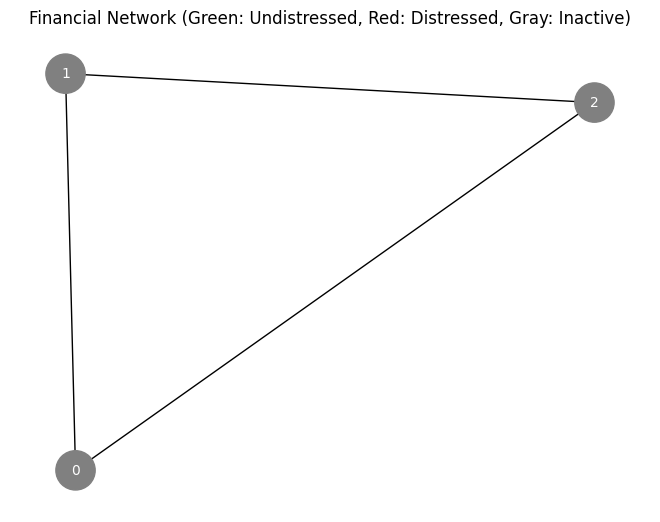

In [29]:
debtrank.visualize_network()

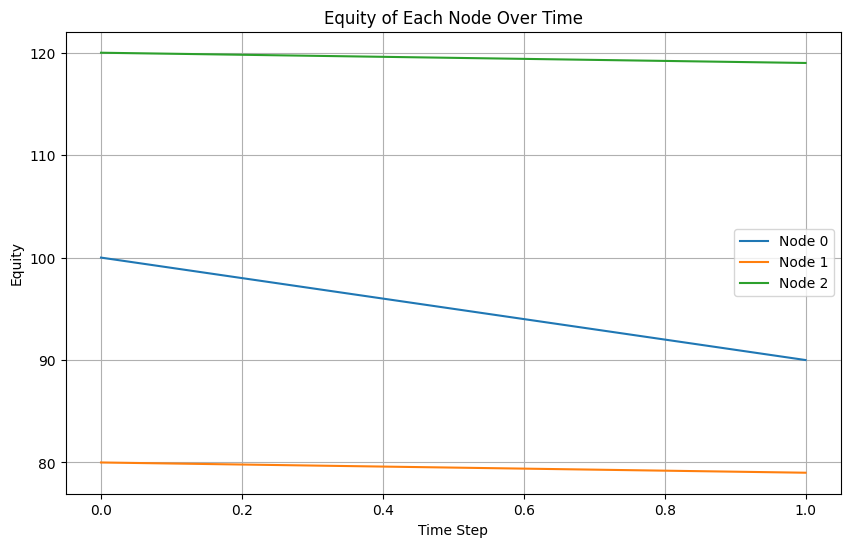

In [30]:
debtrank.visualize_equity_loss()